# Microfinance analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from matplotlib import colors
from copy import deepcopy


%matplotlib inline

In [2]:
from rashomon import tva
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import RAggregate_profile, RAggregate, find_profile_lower_bound, find_feasible_combinations, remove_unused_poolings
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache

%load_ext autoreload
%autoreload 2

# Read data

In [48]:
df = pd.read_csv("../Data/banerjee_miracle.csv")

df.head()

,male_head,anyloan_amt,female_biz_pct,bizexpense,total_exp_mo,home_durable_index,anyloan_amt_2,informal_amt_2,female_biz_pct_2,hours_week_2,durables_exp_mo_2,temptation_exp_mo_2,total_exp_mo_2,bizprofit_2,bizrev_2,bizemployees_2,girls_school
0,2.0,2,2.0,2,2,2,5000.0,0.0,0.0,36.0,1291.1173,0.0,11836.075,2049.1282,2498.9368,0.0,NaN
1,2.0,2,2.0,2,2,2,5000.0,0.0,0.0,36.0,1291.1173,0.0,11836.075,2049.1282,2498.9368,0.0,NaN
2,2.0,2,2.0,2,2,2,5000.0,0.0,0.0,36.0,1291.1173,0.0,11836.075,2049.1282,2498.9368,0.0,NaN
3,2.0,2,2.0,2,2,2,5000.0,0.0,0.0,36.0,1291.1173,0.0,11836.075,2049.1282,2498.9368,0.0,NaN
4,2.0,2,2.0,2,2,2,5000.0,0.0,0.0,36.0,1291.1173,0.0,11836.075,2049.1282,2498.9368,0.0,NaN


In [49]:
cols = df.columns
outcome_cols = cols[6:]

In [68]:
outcome_col_id = 6
outcome_col = cols[outcome_col_id]

df2 = df.copy()
df2[outcome_col] = df[outcome_col].fillna(0)

Z = df2.to_numpy()



X = Z[:, [0, 1, 2, 3, 4]]
y = Z[:, outcome_col_id]
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y = y.reshape((-1, 1))

num_data = X.shape[0]
print(f"There are {num_data} data points")

There are 2800 data points


# Analysis

In [69]:
M = 5
R = np.array([3, 4, 3, 4, 4])

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

all_policies = tva.enumerate_policies(M, R)
num_policies = len(all_policies)

policies_profiles = {}
policies_profiles_masked = {}
policies_ids_profiles = {}
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policies_ids_k = list(unzipped_temp[0])
    policies_k = list(unzipped_temp[1])
    policies_profiles[k] = deepcopy(policies_k)
    policies_ids_profiles[k] = policies_ids_k

    profile_mask = list(map(bool, profile))

    # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    policies_profiles_masked[k] = policies_k

In [70]:
D = np.zeros(shape=y.shape, dtype=np.int64)
profiles_in_data = []
for i in range(num_data):
    policy_i = tuple([int(x) for x in X[i, :]])
    policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
    profiles_in_data.append(tva.policy_to_profile(policy_i))
    D[i, 0] = int(policy_idx[0])

policy_means = loss.compute_policy_means(D, y, num_policies)

In [71]:
nodata_idx = np.where(policy_means[:, 1] == 0)[0]
policy_means[nodata_idx, 0] = -np.inf
policy_means[nodata_idx, 1] = 1
mu_policies = policy_means[:, 0] / policy_means[:, 1]

true_best_eff = np.max(mu_policies)
print(true_best_eff)
np.where(mu_policies == true_best_eff)

1.0


(array([208]),)

(array([2.798e+03, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

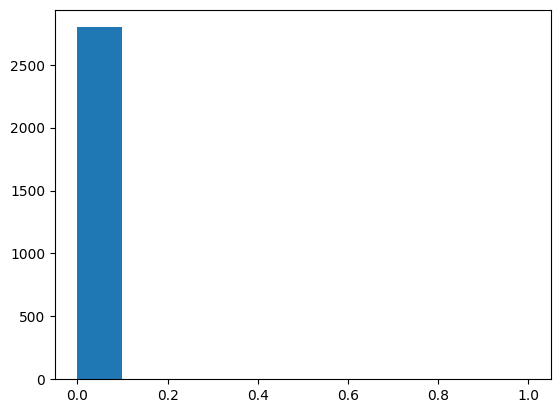

In [72]:
plt.hist(y)

In [59]:
5e-5 - 1.3972041944069919e-05

3.602795805593008e-05

In [81]:
reg = 1e-6
q_0 =  0.0075579
q =  2.5e-5
H = 20
R_set, rashomon_profiles = RAggregate(M, R, H, D, y, q, reg=reg)
# R_set, rashomon_profiles = RAggregate(M, R, 10, D, y, q, reg=reg)

print(len(R_set))

/Users/apara/Documents/Research/2022_Bayesian_TVA/Rashomon/Code/rashomon/aggregate/raggregate.py:46: RuntimeWarning: invalid value encountered in divide
  mu = np.float64(policy_means_k[:, 0]) / policy_means_k[:, 1]
/Users/apara/Documents/Research/2022_Bayesian_TVA/Rashomon/Code/rashomon/aggregate/raggregate.py:46: RuntimeWarning: invalid value encountered in divide
  mu = np.float64(policy_means_k[:, 0]) / policy_means_k[:, 1]
/Users/apara/Documents/Research/2022_Bayesian_TVA/Rashomon/Code/rashomon/aggregate/raggregate.py:46: RuntimeWarning: invalid value encountered in divide
  mu = np.float64(policy_means_k[:, 0]) / policy_means_k[:, 1]
/Users/apara/Documents/Research/2022_Bayesian_TVA/Rashomon/Code/rashomon/aggregate/raggregate.py:46: RuntimeWarning: invalid value encountered in divide
  mu = np.float64(policy_means_k[:, 0]) / policy_means_k[:, 1]
/Users/apara/Documents/Research/2022_Bayesian_TVA/Rashomon/Code/rashomon/aggregate/raggregate.py:46: RuntimeWarning: invalid value encou

1.3972041944069919e-05
(0, 0, 0, 0, 0) 1.1027958055930082e-05
(0, 0, 0, 0, 1) 1.1027958055930082e-05
(0, 0, 0, 1, 0) 1.1027958055930082e-05
(0, 0, 0, 1, 1) 1.1027958055930082e-05
(0, 0, 1, 0, 0) 1.1027958055930082e-05
(0, 0, 1, 0, 1) 1.1027958055930082e-05
(0, 0, 1, 1, 0) 1.1027958055930082e-05
(0, 0, 1, 1, 1) 1.1027958055930082e-05
(0, 1, 0, 0, 0) 1.1027958055930082e-05
(0, 1, 0, 0, 1) 1.1027958055930082e-05
(0, 1, 0, 1, 0) 1.1027958055930082e-05
(0, 1, 0, 1, 1) 1.1027958055930082e-05
(0, 1, 1, 0, 0) 1.1027958055930082e-05
(0, 1, 1, 0, 1) 1.1027958055930082e-05
(0, 1, 1, 1, 0) 1.1027958055930082e-05
(0, 1, 1, 1, 1) 1.1027958055930082e-05
(1, 0, 0, 0, 0) 1.1027958055930082e-05
(1, 0, 0, 0, 1) 1.1027958055930082e-05
(1, 0, 0, 1, 0) 1.1027958055930082e-05
(1, 0, 0, 1, 1) 1.1027958055930082e-05
(1, 0, 1, 0, 0) 1.1027958055930082e-05
4
(1, 0, 1, 0, 1) 1.1027958055930082e-05
15
(1, 0, 1, 1, 0) 1.1027958055930082e-05
(1, 0, 1, 1, 1) 1.1027958055930082e-05
(1, 1, 0, 0, 0) 1.1027958055930082e-

In [80]:
R_set = find_feasible_combinations(rashomon_profiles, 2.5e-5, H, sorted=True)
print(len(R_set))

5271
